In [2]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import sys
sys.path.insert(0, '../')
from utils import *
import sigpy as sp
import sigpy.mri as mr
import cv2

In [3]:
preprocess = lambda x : x / 127 - 1
deprocess  = lambda x :((x + 1) * 127).astype(np.uint8)

def get_image_normalized(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.expand_dims(-1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv))), 2)
    if plot:
        plt.imshow(normalized_img[:, :, 0], cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img


def get_subsampled_normalized(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask)).astype(float)
    minv = np.min(new_img)
    maxv = np.max(new_img)
    normalized_new_img = np.expand_dims(-1 + (2 * (new_img - minv) / (maxv - minv)), 2)
    if plot:
        plt.imshow(normalized_new_img[:, :, 0], cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img
def get_best_L2(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.square(img[:, :, 0] - compare[:, :, 0]))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_best_L1(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.abs(img[:, :, 0] - compare[:, :, 0]))
        #print(mse)
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_best_L1_2chan(all_ims, compare):
    compare = np.sqrt(compare[:, :, 0] ** 2 + compare[:, :, 1] ** 2)
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        img = np.sqrt(img[:, :, 0] ** 2 + img[:, :, 1] ** 2)
        mse = np.mean(np.abs(img - compare))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_wavelet_recon(subs, lamda=0.001): 
    img = subs[:, :, 0].astype(np.complex)
    ksp = sp.fft.fft(img)
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    return np.real(img_l1wav)

def get_wavelet_recon_2chan(subs, lamda=0.001): 
    img = (subs[:, :, 0] + 1j*subs[:, :, 1]).astype(np.complex)
    ksp = sp.fft.fft(img)
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    return np.sqrt(np.real(img_l1wav)**2 + np.imag(img_l1wav)**2)

def get_image_normalized_2chan(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.zeros((320, 256, 2))
    normalized_img_real = -1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv)))
    normalized_img[:, :, 0] = normalized_img_real
    normalized_img[:, :, 1] = img[:, :, 1]
    if plot:
        plt.imshow(np.sqrt(normalized_img[:, :, 0] ** 2 + normalized_img[:, :, 1] ** 2), cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img

def get_batch_normalized_2chan(indices):
    return np.array([get_image_normalized_2chan(ind) for ind in indices])


def get_subsampled_normalized_2chan(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask))
    minv = np.min(np.real(new_img))
    maxv = np.max(np.real(new_img))
    normalized_new_img = np.zeros((320, 256, 2))
    normalized_new_img_real = -1 + (2 * (np.real(new_img) - minv) / (maxv - minv))
    normalized_new_img[:, :, 0] = normalized_new_img_real
    normalized_new_img[:, :, 1] = np.imag(new_img) 
    if plot:
        plt.imshow(np.sqrt(normalized_new_img[:, :, 0] ** 2 + normalized_new_img[:, :, 1] ** 2), cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img
def get_brain_normalized():
    image = cv2.imread('brain.png')
    return preprocess(image)[:, :, 0:1]

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d
GradientMethod:   0%|      

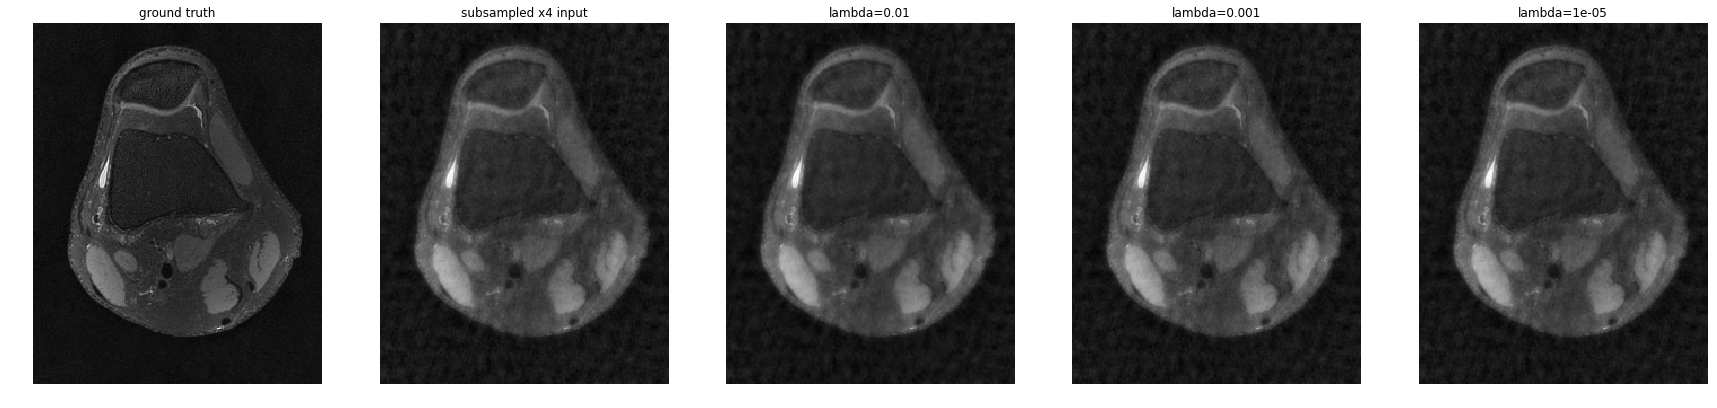

In [4]:
orig_img = get_image_normalized(100, plot=False)
subs_img = get_subsampled_normalized(orig_img, 2, plot=False)
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)
subs_img_6 = get_subsampled_normalized(orig_img, 6, plot=False)
wavelet_subs = get_wavelet_recon(subs_img)
lams = [0.01, 0.001, 0.00001]
wavelet_subs_4s = [get_wavelet_recon(subs_img_4, lam).reshape((320, 256, 1)) for lam in lams]
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('ground truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('subsampled x4 input') ; plt.imshow(subs_img_4[:, :, 0], cmap='gray')

for i in range(len(lams)):
    plt.subplot(153 + i); plt.axis('off'); plt.title('lambda={}'.format(lams[i])); plt.imshow(wavelet_subs_4s[i][:, :, 0], cmap='gray')
plt.show()


c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


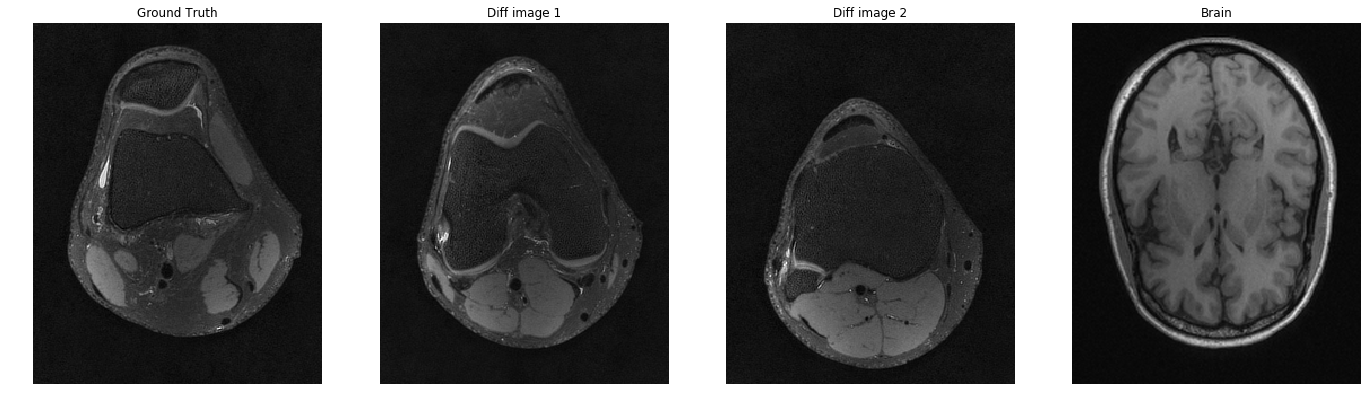

Reconstructions on subsampled x4:
Trial 0


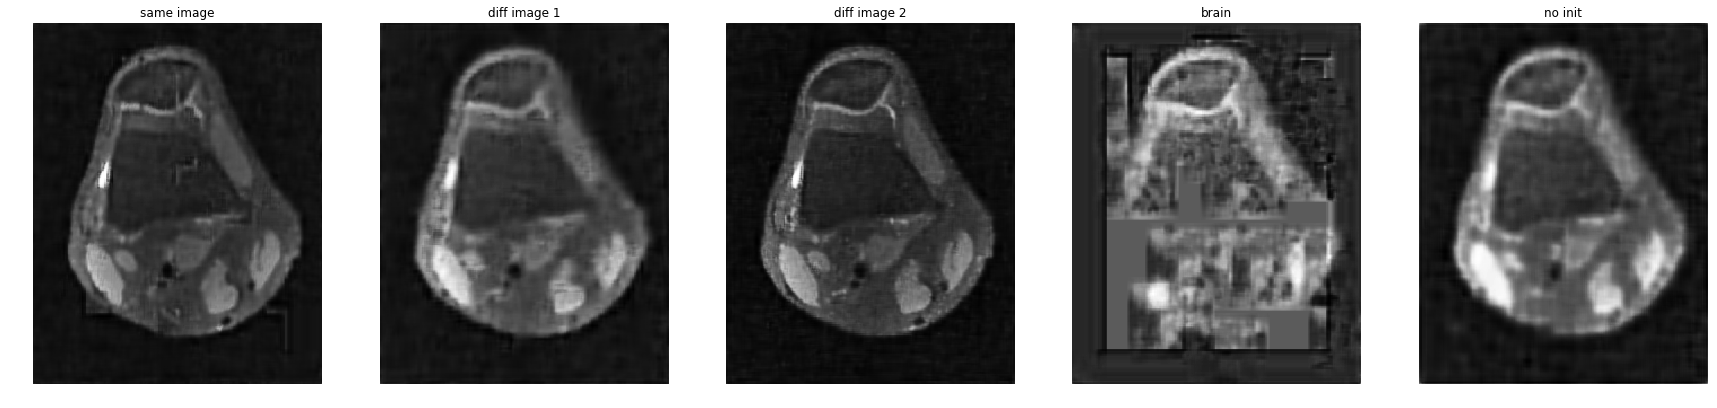

L1 errors:  [0.07759406972738922, 0.07887488327146647, 0.08086756722879954, 0.10495728382494411, 0.07067935074564367]
L2 errors:  [0.011958616875941278, 0.012561418013883847, 0.012582956041225455, 0.02342341360968133, 0.010760694964574876]
Trial 1


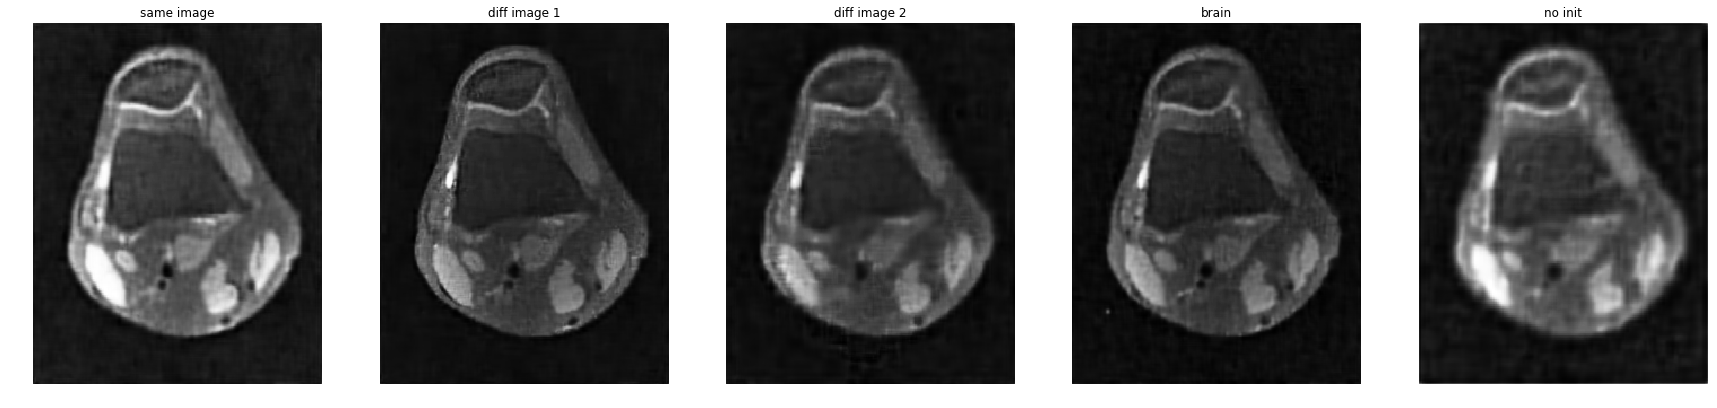

L1 errors:  [0.07470504090295155, 0.07907613562480524, 0.07870096301409354, 0.07837007872857867, 0.07190738173496664]
L2 errors:  [0.010557922682135918, 0.01195622518564671, 0.012325770636984352, 0.01203112007890638, 0.010999891272291912]
Trial 2


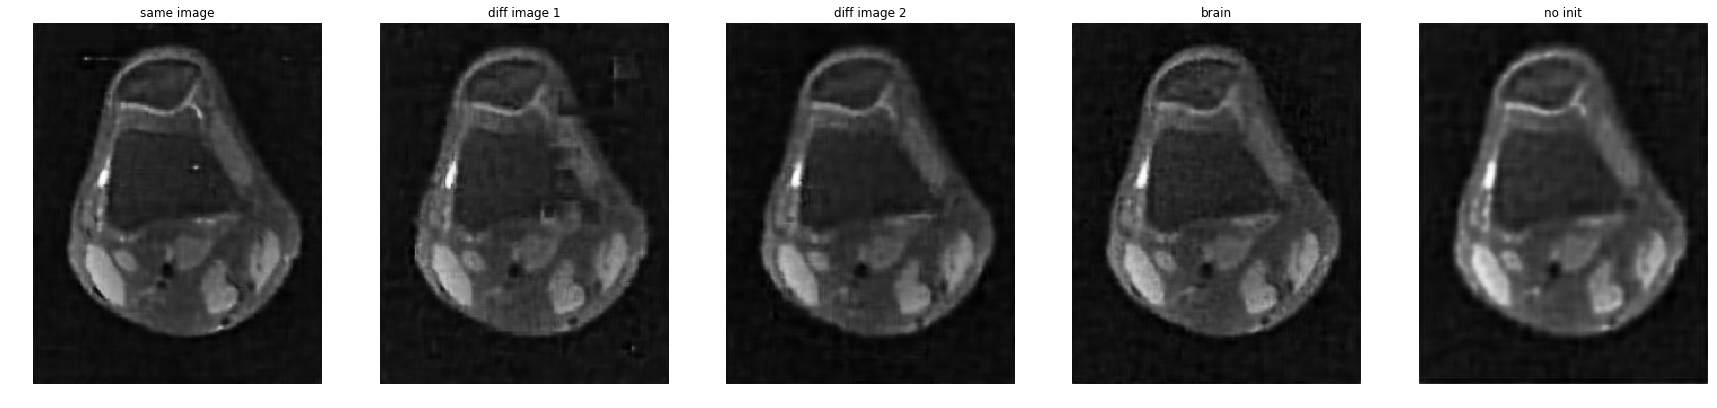

L1 errors:  [0.0776981515772995, 0.08283526010525115, 0.07469753197634321, 0.07925168269225934, 0.07617378223915029]
L2 errors:  [0.011812037523753888, 0.013362244551853928, 0.011572982845269173, 0.012150678616331966, 0.011477557834625026]


In [5]:
# compare init with same image, diff image 1, diff image 2, brain, no init
# feed in same noise for init train (pure noise)
# recon compared to 4x subsample
# feed in same noise for recon (pure noise)
# 70x25 train init and recon iterations at 1e-3 learning rate with jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(170, plot=False)
diff_img2 = get_image_normalized(240, plot=False)
brain = get_brain_normalized()
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)


all_results = np.load('../deep_prior_data/init_compare/diff_inits_L1.npy')
trials = 3
titles = ['same image', 'diff image 1', 'diff image 2', 'brain', 'no init']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Diff image 1'); plt.imshow(diff_img1[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Diff image 2'); plt.imshow(diff_img2[:, :, 0], cmap='gray')
plt.subplot(154); plt.axis('off'); plt.title('Brain'); plt.imshow(brain[:, :, 0], cmap='gray')
plt.show()
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(5): 
        curr = all_results[j][i]
        best, ind = get_best_L1(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


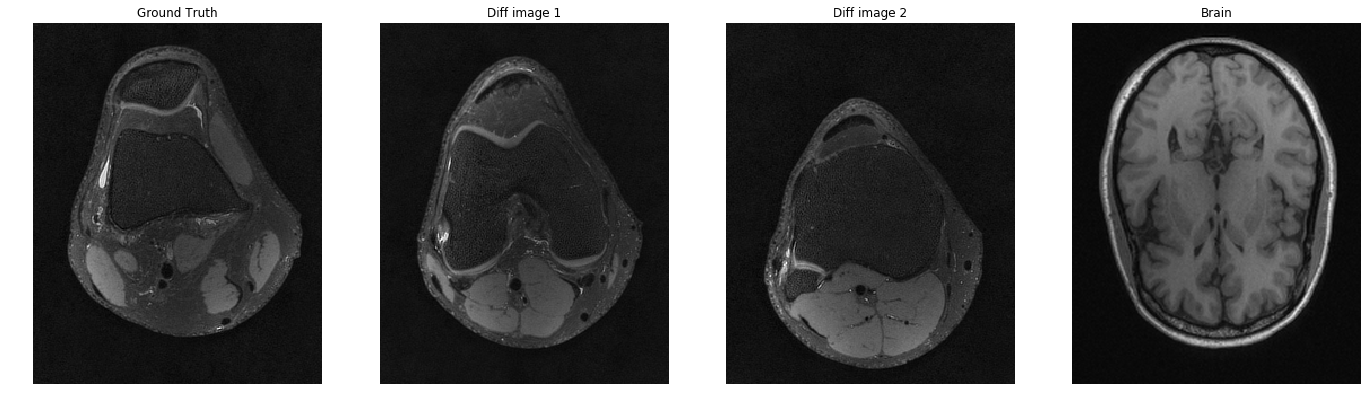

Reconstructions on subsampled x4:
Trial 0


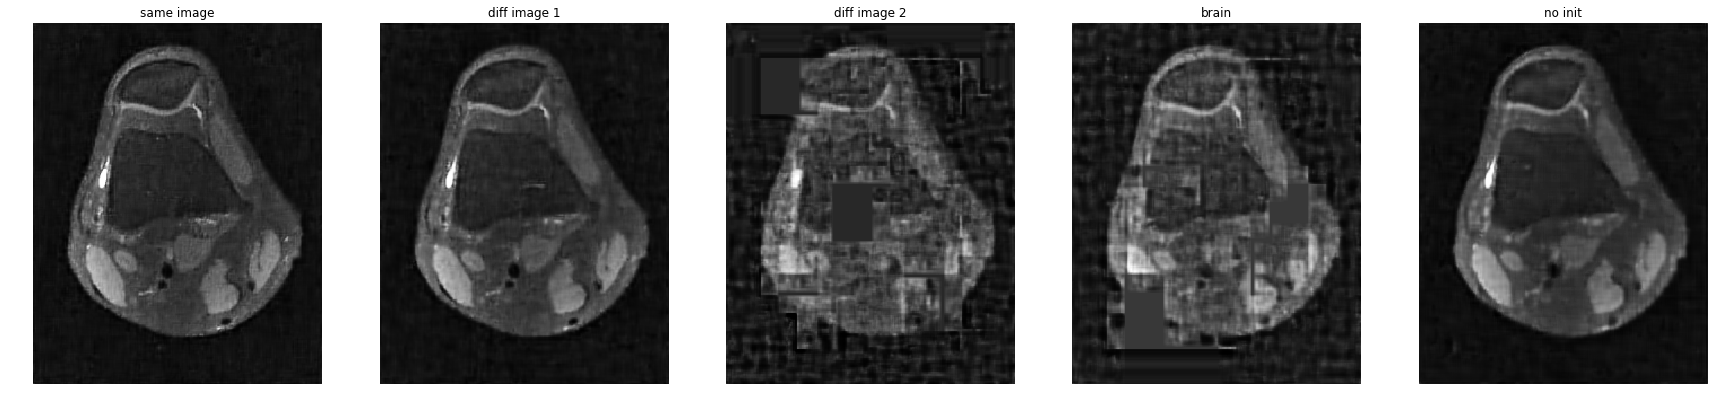

L1 errors:  [0.08555974017634713, 0.08617637724533282, 0.11245205825137214, 0.10777244691474479, 0.08548183786330317]
L2 errors:  [0.0133394767160871, 0.013554744543018426, 0.024028713105531684, 0.023061712399029752, 0.01349577540195697]
Trial 1


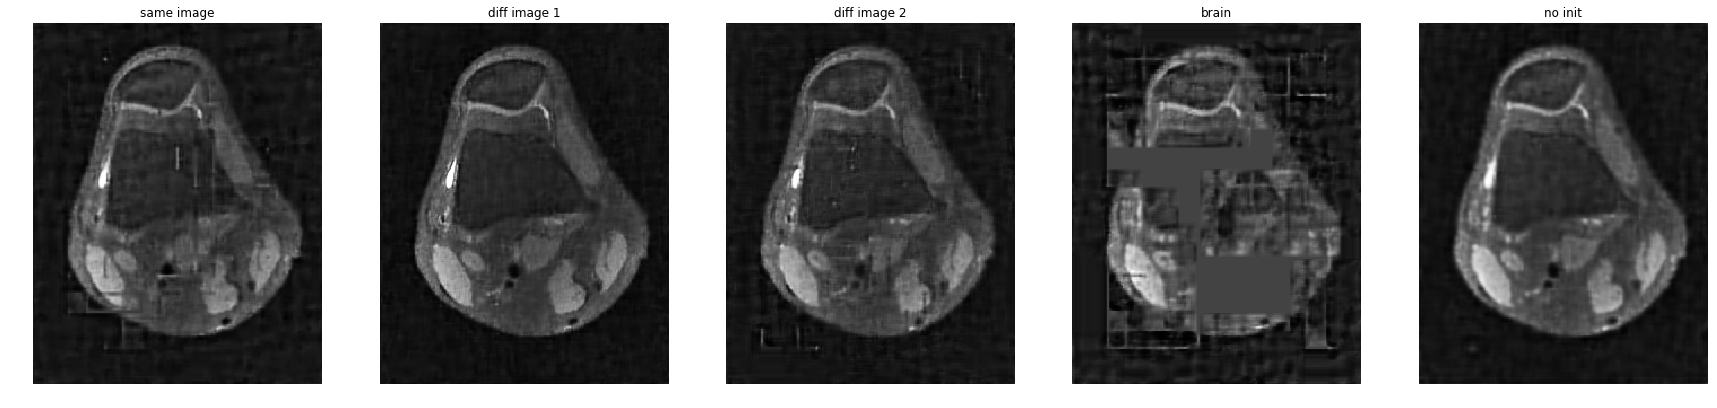

L1 errors:  [0.09156554285001649, 0.08595842366649122, 0.08958270286087568, 0.10939450266427919, 0.08632248147322094]
L2 errors:  [0.015728230706138182, 0.013420284226678143, 0.014784924572776071, 0.023273236889462784, 0.013828392301263068]
Trial 2


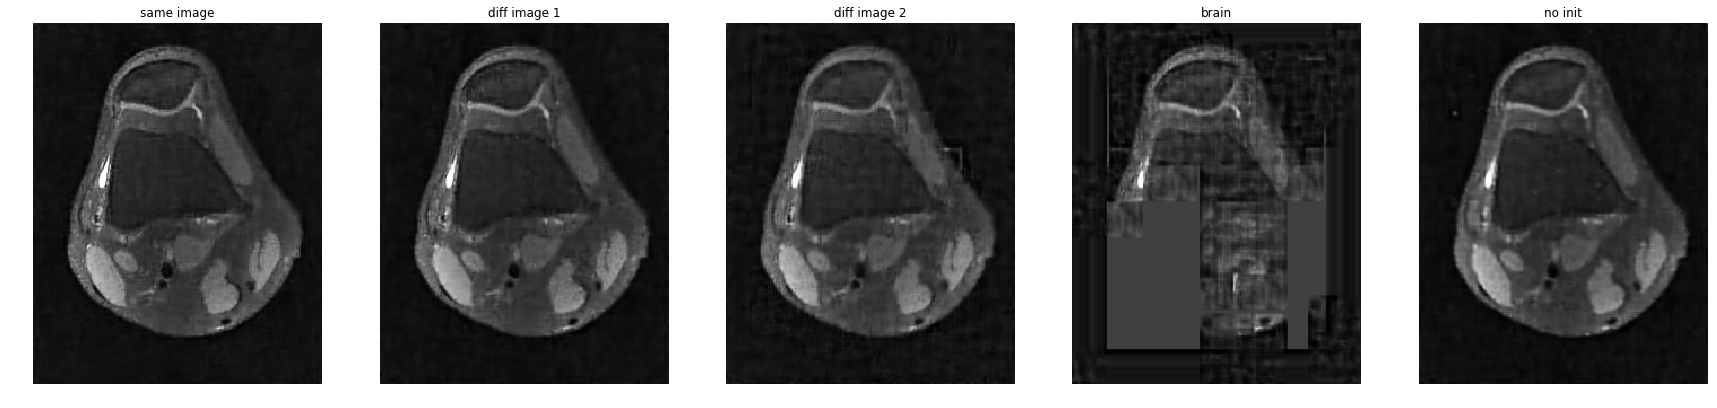

L1 errors:  [0.08466852001493903, 0.08519961325591432, 0.08745169255309454, 0.11713890780993845, 0.08487231846415029]
L2 errors:  [0.01300287606045666, 0.013224465172375622, 0.014075576271586423, 0.02614668977934544, 0.01329917502382912]


In [10]:
# compare init with same image, diff image 1, diff image 2, brain, no init
# feed in same noise for init train (pure noise)
# recon with 4x subsample
# feed in same noise for recon (2x subsampled ground truth - in effort to simulate feeding in wavelet recon output)
# 70x25 train init and recon iterations at 1e-3 learning rate with jittering
# 70x25 recon iterations at 1e-4 learning rate with minimal jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(170, plot=False)
diff_img2 = get_image_normalized(240, plot=False)
brain = get_brain_normalized()
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)


all_results = np.load('../deep_prior_data/init_compare/diff_inits_L1_feedrecon.npy')
trials = 3
titles = ['same image', 'diff image 1', 'diff image 2', 'brain', 'no init']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Diff image 1'); plt.imshow(diff_img1[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Diff image 2'); plt.imshow(diff_img2[:, :, 0], cmap='gray')
plt.subplot(154); plt.axis('off'); plt.title('Brain'); plt.imshow(brain[:, :, 0], cmap='gray')
plt.show()
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(5): 
        curr = all_results[j][i]
        best, ind = get_best_L1(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


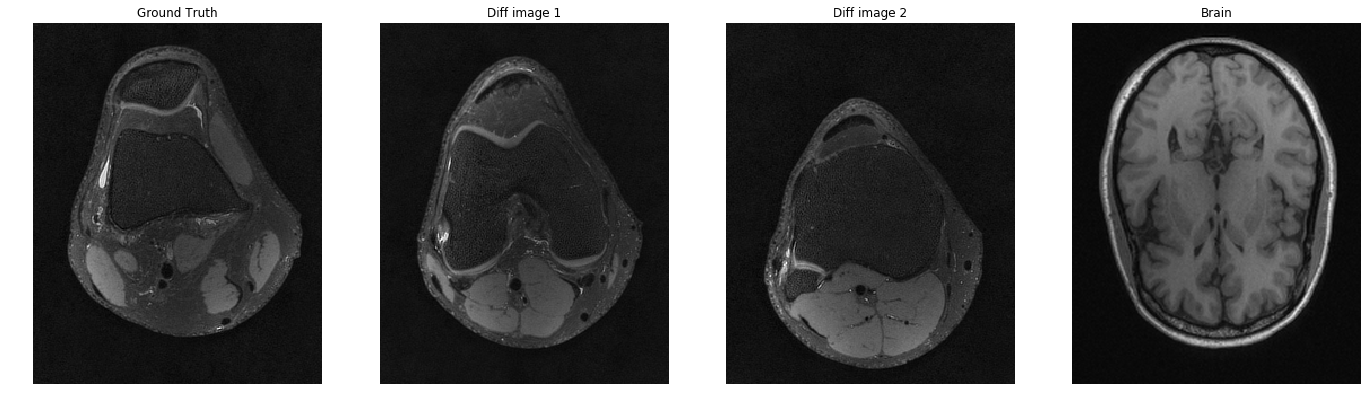

Reconstructions on subsampled x4:
Trial 0


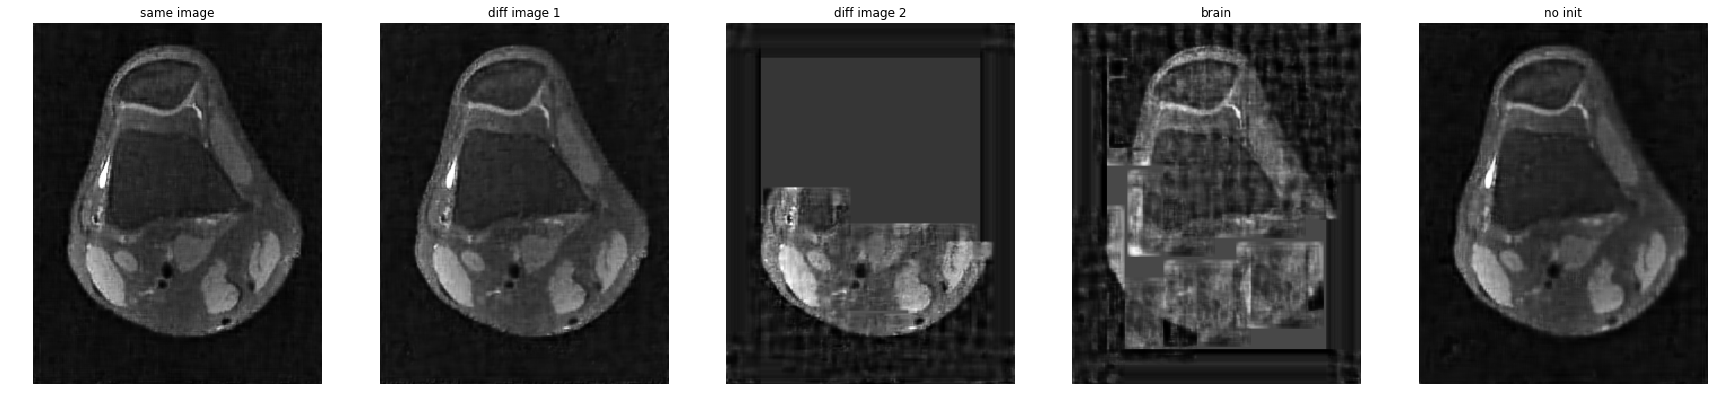

L1 errors:  [0.08505392391055971, 0.08589338428940874, 0.10888431103560621, 0.12094611767776293, 0.08570497102866315]
L2 errors:  [0.013093166363454247, 0.013463795761301458, 0.02250500175270076, 0.027939831676184645, 0.013588123882848243]
Trial 1


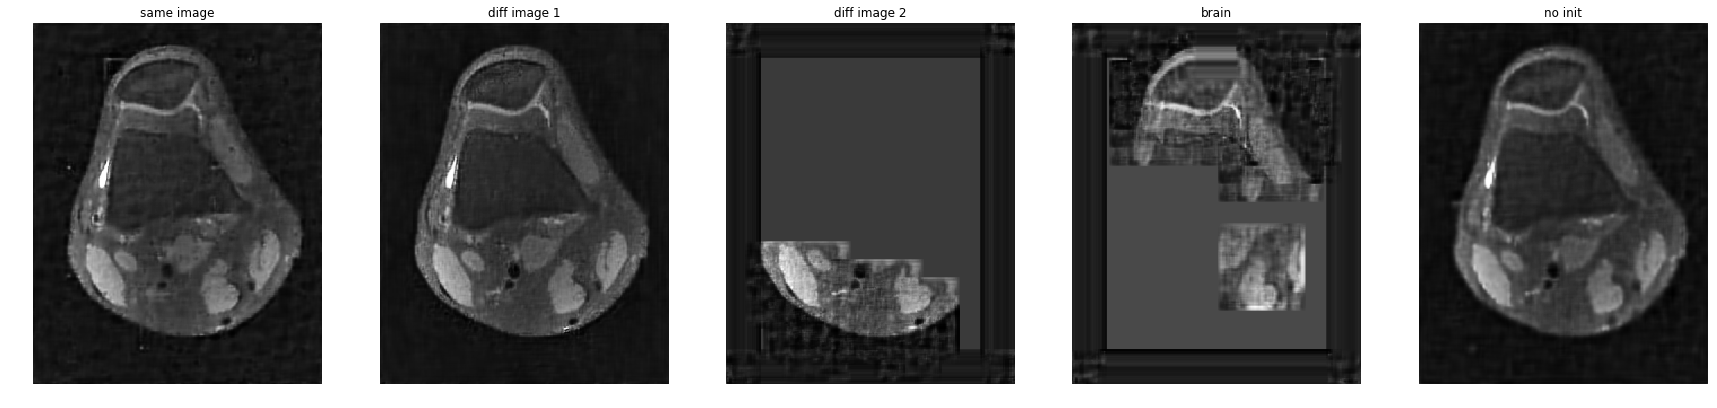

L1 errors:  [0.08817052962784719, 0.08506313585769237, 0.11720280747268445, 0.11742007326853048, 0.0862892476995845]
L2 errors:  [0.014141652802098378, 0.01312480499979345, 0.025678550809308653, 0.02716592359345183, 0.013733442494003049]
Trial 2


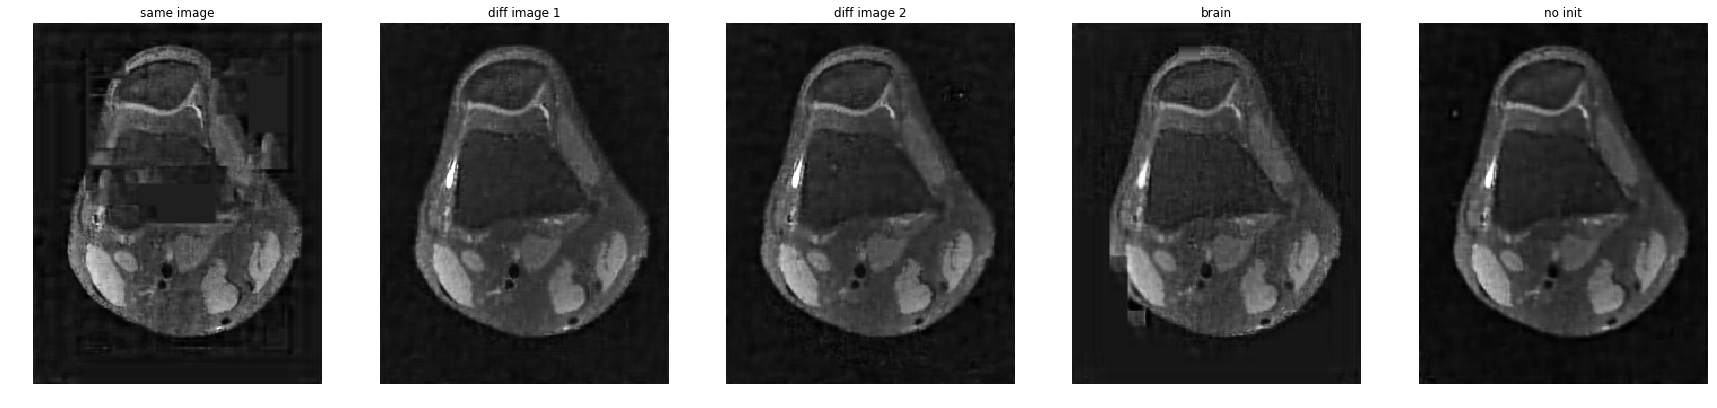

L1 errors:  [0.09379634872016876, 0.08529693539940802, 0.08624227974576891, 0.08758756475700213, 0.08490872361888113]
L2 errors:  [0.017244632200014536, 0.013330144963756322, 0.013496090018450674, 0.014420795424273367, 0.013245821320330605]


In [12]:
# compare init with same image, diff image 1, diff image 2, brain, no init
# feed in 2x subsampled input foreach init task train
# recon with 4x subsample
# feed in same noise for recon (2x subsampled ground truth - in effort to simulate feeding in wavelet recon output)
# 70x25 train init and recon iterations at 1e-3 learning rate with jittering
# 70x25 recon iterations at 1e-4 learning rate with minimal jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(170, plot=False)
diff_img2 = get_image_normalized(240, plot=False)
brain = get_brain_normalized()
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)


all_results = np.load('../deep_prior_data/init_compare/diff_inits_L1_trainfeedrecon.npy')
trials = 3
titles = ['same image', 'diff image 1', 'diff image 2', 'brain', 'no init']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Diff image 1'); plt.imshow(diff_img1[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Diff image 2'); plt.imshow(diff_img2[:, :, 0], cmap='gray')
plt.subplot(154); plt.axis('off'); plt.title('Brain'); plt.imshow(brain[:, :, 0], cmap='gray')
plt.show()
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(5): 
        curr = all_results[j][i]
        best, ind = get_best_L1(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


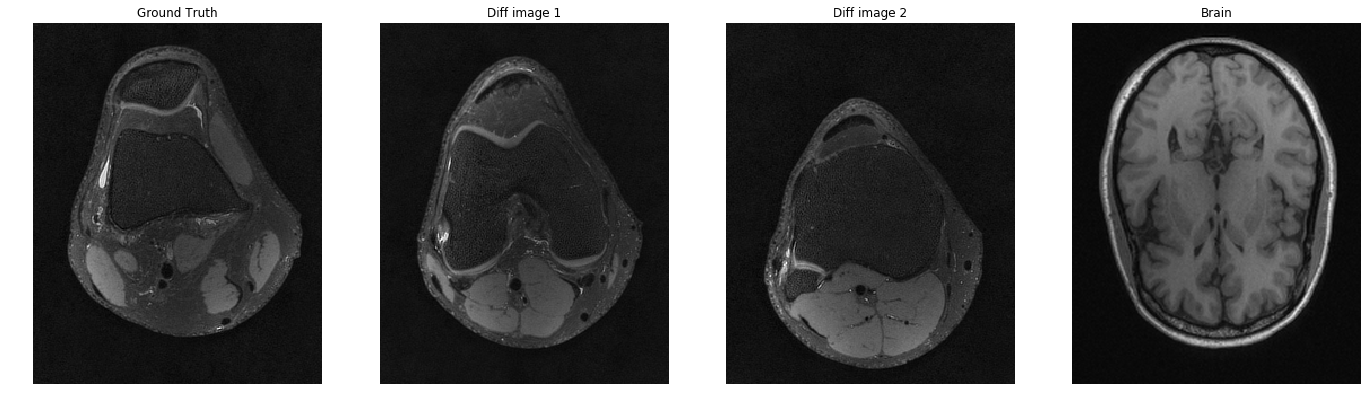

Reconstructions on subsampled x4:
Trial 0


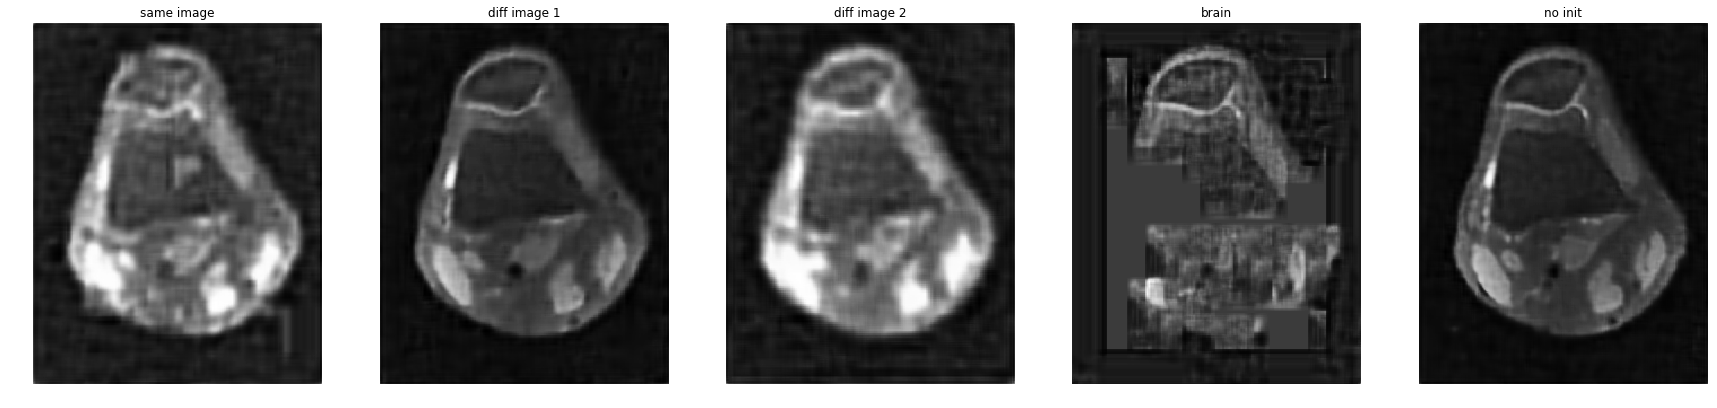

L1 errors:  [0.07405142765329567, 0.07754620439282392, 0.07643129801910328, 0.10825476645378793, 0.07456649371457805]
L2 errors:  [0.011809607386283286, 0.011857528841541547, 0.012114045255879604, 0.024841336708415547, 0.011220545353542635]
Trial 1


L1 errors:  [0.07639720298251201, 0.0790529646153357, 0.0711325741174378, 0.07619372537824981, 0.07639569018416296]
L2 errors:  [0.01167789735331801, 0.012256989002415621, 0.01130123034841113, 0.01155885675614943, 0.012214479145378921]
Trial 2


L1 errors:  [0.07774422495342363, 0.07575543203400259, 0.0762627003699075, 0.0766330783468602, 0.07699720787850356]
L2 errors:  [0.012285730939793222, 0.01157583265505958, 0.011366035009590091, 0.011581886656469982, 0.011512912803048147]


In [5]:
# compare init with same image, diff image 1, diff image 2, brain, no init
# feed in 2x subsampled input foreach init task train
# recon with 4x subsample
# feed in same noise for recon (2x subsampled ground truth - in effort to simulate feeding in wavelet recon output)
# 70x25 train init and recon iterations at 1e-3 learning rate with jittering
# 70x25 recon iterations at 1e-4 learning rate with minimal jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(170, plot=False)
diff_img2 = get_image_normalized(240, plot=False)
brain = get_brain_normalized()
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)


all_results = np.load('../deep_prior_data/init_compare/diff_inits_L1_lesstrain.npy')
trials = 3
titles = ['same image', 'diff image 1', 'diff image 2', 'brain', 'no init']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Diff image 1'); plt.imshow(diff_img1[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Diff image 2'); plt.imshow(diff_img2[:, :, 0], cmap='gray')
plt.subplot(154); plt.axis('off'); plt.title('Brain'); plt.imshow(brain[:, :, 0], cmap='gray')
plt.show()
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(5): 
        curr = all_results[j][i]
        best, ind = get_best_L1(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)